In [1]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_3415/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


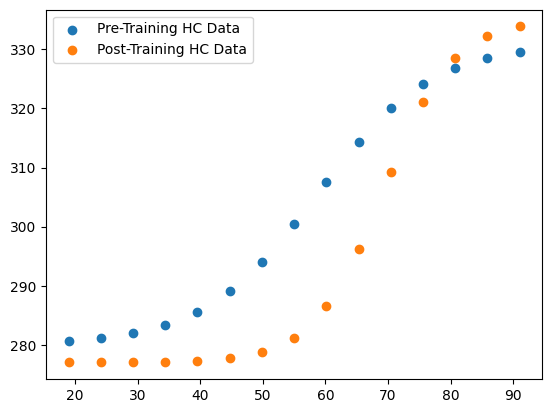

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs, label="Pre-Training HC Data")

##Post-Training
###Healthy Controls
ymin = 277
ymax = 335
fpostHCCP = 100 - 1.028 * v
fpostHCS = 1 / 0.18  # negative

HC_RTs_post = RTsig(mydistances, fpostHCCP, fpostHCS)
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.legend()

In [3]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

k_a = 5e-05
k_v = 5e-05
stim_counts = 10


def train_hcmodel(theta):
    rho_0 = theta[0]
    sigav_x = theta[1]
    locav_x = theta[2]

    HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
        stim_counts,
        simtime,
        ts,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        rho_0,
        6.5,
        6.5,
        k_a,
        k_v,
        0.05,
        sigav_x,
        locav_x,
    )

    _, _, _, _, HCrtpost = experiment(
        ts,
        simtime,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa_tr[:, :, -1, -1],
        HCWv_tr[:, :, -1, -1],
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrtpost
    yf = HC_RTs_post

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 0.1), (0.01, 9), (32, 100)]
train_hcmodel_res = differential_evolution(
    train_hcmodel, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 76.81363051277121
differential_evolution step 2: f(x)= 72.66466983287069
differential_evolution step 3: f(x)= 72.66466983287069
differential_evolution step 4: f(x)= 72.66466983287069
differential_evolution step 5: f(x)= 72.66466983287069
differential_evolution step 6: f(x)= 72.66466983287069
differential_evolution step 7: f(x)= 72.20813726394672
differential_evolution step 8: f(x)= 72.20813726394672
differential_evolution step 9: f(x)= 72.20813726394672
differential_evolution step 10: f(x)= 72.20813726394672
differential_evolution step 11: f(x)= 71.71128215641997
differential_evolution step 12: f(x)= 71.71128215641997
differential_evolution step 13: f(x)= 71.71128215641997
differential_evolution step 14: f(x)= 71.71128215641997
differential_evolution step 15: f(x)= 71.71128215641997
differential_evolution step 16: f(x)= 71.5944839153415
differential_evolution step 17: f(x)= 71.5944839153415
differential_evolution step 18: f(x)= 71.5944839153415
diff

In [5]:
print(train_hcmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 71.5944839153415
                   x: [ 3.399e-02  8.018e+00  3.521e+01]
                 nit: 23
                nfev: 1080
          population: [[ 3.399e-02  8.018e+00  3.521e+01]
                       [ 1.804e-02  4.667e+00  4.130e+01]
                       ...
                       [ 3.185e-02  7.952e+00  3.531e+01]
                       [ 3.194e-02  7.955e+00  3.531e+01]]
 population_energies: [ 7.159e+01  7.310e+01 ...  7.223e+01  7.223e+01]


In [6]:
## Fitted model

rho_0, siagav_x, locav_x = 3.399e-02, 8.018e00, 3.521e01

# (2.005e-03, 5.041e00, 4.895e01)
# 1.633e-02, 9.858e-01 #6.222e-07

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    siagav_x,
    locav_x,
)


_, _, _, _, HC_Model_RTs_post = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa_tr[:, :, -1, -1],
    HCWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_Model_RTs_post = fit_RT(HC_Model_RTs_post, HC_RTs_post)

In [7]:
_, _, _, _, HC_Model_RTs_pre = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_RTs_model_pre = fit_RT(HC_Model_RTs_pre, HC_RTs)

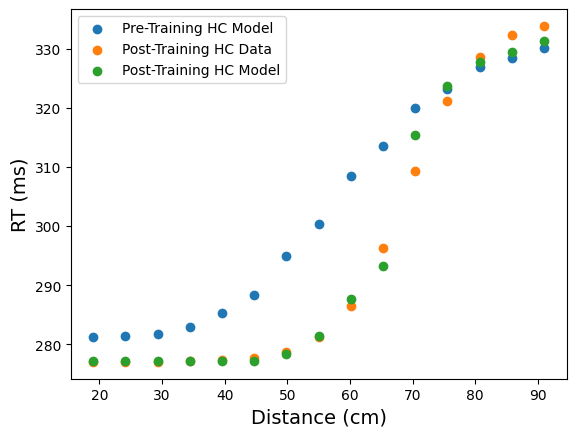

In [8]:
plt.scatter(mydistances, HC_RTs_model_pre, label="Pre-Training HC Model")
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.scatter(mydistances, HC_Model_RTs_post, label="Post-Training HC Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()